In [2]:
import seaborn as sns

sns.set_theme(
    palette="viridis",
    style="whitegrid"
)

In [3]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer

# Load the event logs
domestic_log = xes_importer.apply('Data/DomesticDeclarations.xes')
international_log = xes_importer.apply('Data/InternationalDeclarations.xes')

# Print the summary of the logs to understand the structure
domestic_summary = pm4py.get_event_attributes(domestic_log)
international_summary = pm4py.get_event_attributes(international_log)

domestic_summary, international_summary


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

(['concept:name', 'org:role', 'org:resource', 'id', 'time:timestamp'],
 ['concept:name', 'org:role', 'org:resource', 'id', 'time:timestamp'])

In [4]:
import pandas as pd
from pm4py.statistics.traces.generic.log import case_statistics

# Get the unique activities
domestic_activities = set(event["concept:name"] for trace in domestic_log for event in trace)
international_activities = set(event["concept:name"] for trace in international_log for event in trace)

# Get the number of cases
domestic_case_count = len(domestic_log)
international_case_count = len(international_log)

# Get case durations (cycle times)
domestic_case_durations = case_statistics.get_all_case_durations(domestic_log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})
international_case_durations = case_statistics.get_all_case_durations(international_log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})

# Convert durations to DataFrame for easier analysis
domestic_durations_df = pd.DataFrame(domestic_case_durations)
international_durations_df = pd.DataFrame(international_case_durations)

## Can you think of useful KPIs for the processes?

Für die Analyse der Inlands- und Auslandsabrechnungsprozesse an der TU/e werden klare Ziele und Erfolgsfaktoren definiert. Diese dienen als Grundlage für die Identifizierung relevanter KPIs (Key Performance Indicators), mit denen sich die Prozessleistung messen und verbessern lässt.

### KPIs Inlandsabrechnungsprozess

Im Inlandsabrechnungsprozess liegt der Fokus auf der Effizienz, der Genauigkeit und der Einhaltung von Richtlinien. Um diese Ziele zu erreichen, ist es entscheidend, die **Durchlaufzeit** zu überwachen, also die Zeitspanne von der Einreichung einer Abrechnung bis zur finalen Zahlung. Eine kurze Durchlaufzeit trägt maßgeblich zur Effizienz bei. Weiterhin ist es wichtig, die **Genehmigungszeiten** in den verschiedenen Prozessstufen zu messen, um potenzielle Engpässe frühzeitig zu erkennen. Die **Ablehnungsquote** zeigt auf, in welchem Umfang Abrechnungen in den jeweiligen Genehmigungsstufen abgelehnt werden, was direkt die Genauigkeit und Compliance beeinflusst. Schließlich gibt der **Durchsatz**, also die Anzahl der monatlich abgeschlossenen Fälle, Auskunft über die Leistungsfähigkeit des gesamten Prozesses.

#### **Durchlaufzeit (Cycle Time)**

Die **Durchlaufzeit** misst die Zeitspanne von der Einreichung einer Abrechnung bis zur finalen Zahlung. Eine kurze Durchlaufzeit ist entscheidend für die Effizienz des Prozesses. Dieser KPI hilft uns zu verstehen, wie lange der gesamte Prozess durchschnittlich dauert und ob es dabei signifikante Abweichungen gibt.

##### **Mathematische Definition:**

Die Durchlaufzeit $\text{Cycle Time}$ für eine Abrechnung $i$ wird berechnet als die Differenz zwischen dem Zeitpunkt der Einreichung $t_{\text{Einreichung}, i}$ und dem Zeitpunkt der Zahlung $t_{\text{Zahlung}, i}$:

$$
\text{Cycle Time}_i = t_{\text{Zahlung}, i} - t_{\text{Einreichung}, i}
$$

Für den KPI betrachten wir die durchschnittliche Durchlaufzeit über alle Abrechnungen:

$$
\text{Durchschnittliche Cycle Time} = \frac{1}{N} \sum_{i=1}^{N} \text{Cycle Time}_i
$$

Dabei ist $N$ die Gesamtzahl der Abrechnungen.

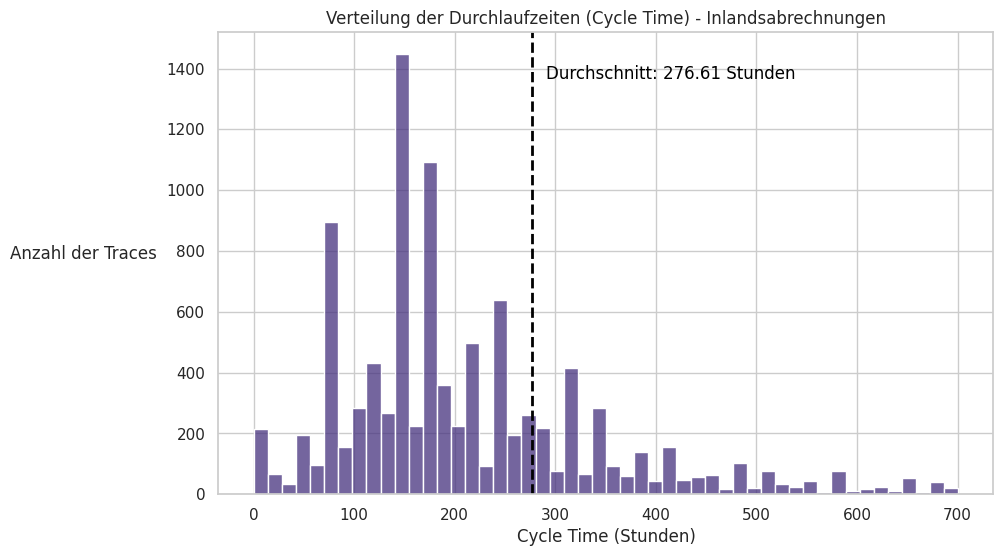

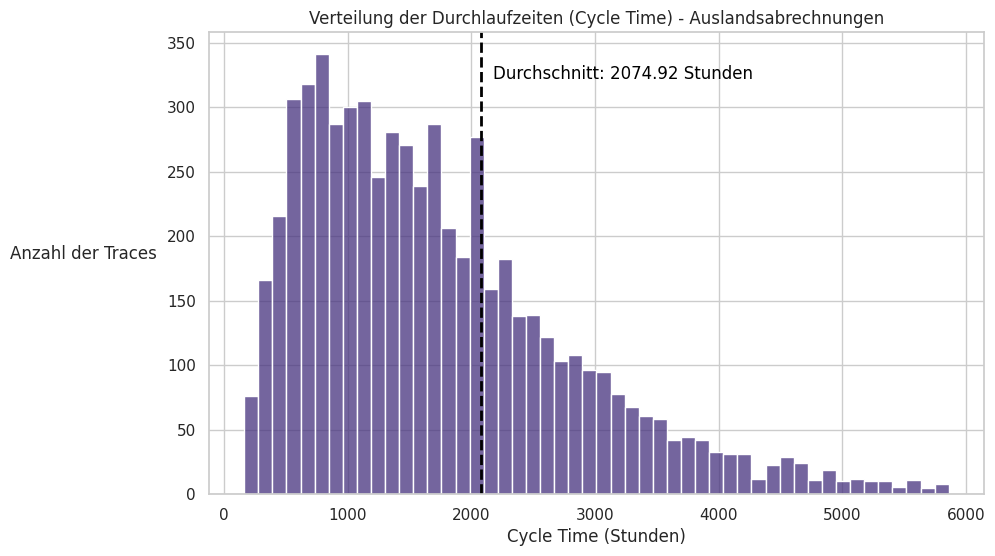

(276.61323227513225, 2074.9211875656865)

In [8]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.statistics.traces.generic.log import case_statistics

def plot_cycle_time(log, title) -> float:
    """
    Berechnet und visualisiert die Durchlaufzeit (Cycle Time) eines Prozesses.

    Parameters:
    log: pm4py.objects.log.obj.EventLog
        Das Event-Log des Prozesses.
    title: str
        Der Titel für den Plot.
    """
    # Berechnung der Durchlaufzeit für jede Abrechnung
    case_durations = case_statistics.get_all_case_durations(log, parameters={
        case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
    })

    # Umwandlung in DataFrame für die Analyse
    durations_df = pd.DataFrame(case_durations, columns=['Cycle Time'])

    # Konvertierung der Durchlaufzeit von Sekunden in Stunden
    durations_df['Cycle Time (Hours)'] = durations_df['Cycle Time'] / 3600

    # Berechnung der durchschnittlichen Durchlaufzeit in Stunden
    average_cycle_time_hours = durations_df['Cycle Time (Hours)'].mean()

    # Beschränkung der Darstellung auf die 95. Perzentile zur Reduktion von Ausreißern
    upper_limit_hours = durations_df['Cycle Time (Hours)'].quantile(0.95)
    filtered_durations = durations_df[durations_df['Cycle Time (Hours)'] <= upper_limit_hours]

    # Plotten der Verteilung der Durchlaufzeiten in Stunden mit Seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_durations['Cycle Time (Hours)'], bins=50, kde=False)
    plt.axvline(average_cycle_time_hours, color='black', linestyle='dashed', linewidth=2)
    plt.text(
        average_cycle_time_hours + average_cycle_time_hours*0.05, # mit offset, damit der Te
        plt.ylim()[1] * 0.9, 
        f'Durchschnitt: {average_cycle_time_hours:.2f} Stunden',
        color='black'
        )
    plt.title(f'Verteilung der Durchlaufzeiten (Cycle Time) - {title}')
    plt.xlabel('Cycle Time (Stunden)')
    plt.ylabel('Anzahl der Traces', rotation=0, labelpad=60)
    plt.show()

    return average_cycle_time_hours

# Nutzung der Funktion für Inlandsabrechnungen
average_domestic_cycle_time = plot_cycle_time(domestic_log, 'Inlandsabrechnungen')

# Nutzung der Funktion für Auslandsabrechnungen
average_international_cycle_time = plot_cycle_time(international_log, 'Auslandsabrechnungen')

# Ausgabe der durchschnittlichen Durchlaufzeiten
average_domestic_cycle_time, average_international_cycle_time


#### **Ablehnungsquote (Rejection Rate)**

Die **Ablehnungsquote** gibt an, wie häufig Abrechnungen in den verschiedenen Phasen des Inlandsabrechnungsprozesses abgelehnt werden. Eine hohe Ablehnungsquote kann auf Probleme in der Qualität der eingereichten Anträge oder auf ineffiziente Genehmigungsprozesse hinweisen. Dieser KPI ist entscheidend für die Verbesserung der Genauigkeit und Compliance im Prozess.

#### **Mathematische Definition:**

Die Ablehnungsquote $\text{Rejection Rate}$ in einer Phase $j$ wird berechnet als das Verhältnis der abgelehnten Abrechnungen $R_j$ zur Gesamtzahl der in diese Phase eingetretenen Abrechnungen $N_j$:

$$
\text{Rejection Rate}_j = \frac{R_j}{N_j} \times 100\%
$$

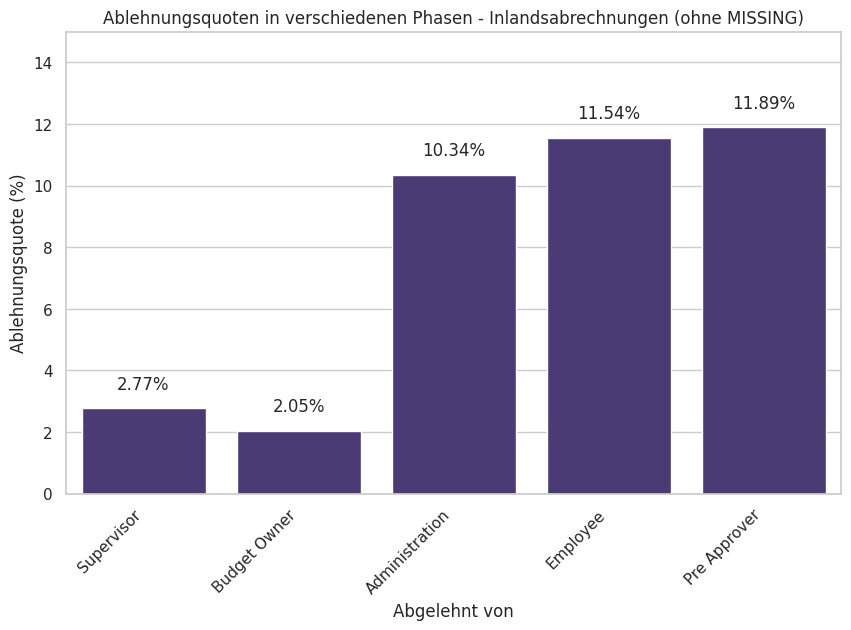

In [12]:
# Funktion zur Berechnung der Ablehnungsquote pro Phase
def calculate_rejection_rate(log, phase):
    total_cases_in_phase = 0
    rejected_cases_in_phase = 0
    for trace in log:
        phase_found = False
        rejected_in_this_phase = False
        for event in trace:
            if phase in event["concept:name"]:
                phase_found = True
            if phase in event["concept:name"] and "REJECTED" in event["concept:name"]:
                rejected_in_this_phase = True
        if phase_found:
            total_cases_in_phase += 1
            if rejected_in_this_phase:
                rejected_cases_in_phase += 1
    
    return (rejected_cases_in_phase / total_cases_in_phase) * 100 if total_cases_in_phase > 0 else 0

# Phasen ohne MISSING-Phase
phases = [
    "SUPERVISOR", 
    "BUDGET OWNER", 
    "ADMINISTRATION", 
    "EMPLOYEE", 
    "PRE_APPROVER"
]

# Berechnung der Ablehnungsquoten ohne `MISSING`-Phase
rejection_rates = {phase.title().replace("_", " "): calculate_rejection_rate(domestic_log, phase) for phase in phases}

# Umwandlung der Daten in ein DataFrame für Seaborn
rejection_rates_df = pd.DataFrame(list(rejection_rates.items()), columns=['Phase', 'Rejection Rate'])

# Plot der Ablehnungsquoten mit Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Phase', y='Rejection Rate', data=rejection_rates_df)

# Titel und Achsenbeschriftungen
plt.title('Ablehnungsquoten in verschiedenen Phasen - Inlandsabrechnungen (ohne MISSING)')
plt.xlabel('Abgelehnt von')
plt.ylabel('Ablehnungsquote (%)')

# Prozentwerte über den Balken anzeigen
for index, row in rejection_rates_df.iterrows():
    plt.text(index, row['Rejection Rate'] + 0.5, f"{row['Rejection Rate']:.2f}%", ha='center', va='bottom')

# Rotieren der x-Achsen-Beschriftungen
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 15)

plt.show()


Die Grafik zeigt die Ablehnungsquoten in den verschiedenen Phasen des Inlandsabrechnungsprozesses. Es fällt auf, dass die höchsten Ablehnungsquoten in den Phasen "Pre Approver" (11,89%) und "Employee" (11,54%) auftreten, gefolgt von der "Administration" (10,34%). Diese Phasen könnten potenzielle Engpässe darstellen, die eine genauere Analyse und möglicherweise eine Prozessoptimierung erfordern. Im Vergleich dazu sind die Ablehnungsquoten in den Phasen "Supervisor" (2,77%) und "Budget Owner" (2,05%) deutlich niedriger, was auf weniger strenge Prüfungen oder eine bessere Qualität der eingereichten Abrechnungen hinweisen könnte.

#### **Durchsatz (Throughput)**

Der **Durchsatz** misst die Anzahl der Abrechnungen, die innerhalb eines bestimmten Zeitraums abgeschlossen werden. Dieser KPI hilft uns zu verstehen, wie effizient der Prozess insgesamt arbeitet und ob es Perioden mit höherer oder niedrigerer Bearbeitungsrate gibt.

#### **Mathematische Definition:**

Der Durchsatz $\text{Throughput}$ wird als die Anzahl der abgeschlossenen Fälle $C(t)$ in einem bestimmten Zeitraum $T$ berechnet:

$$
\text{Throughput} = \frac{C(t)}{T}
$$

Dabei kann $T$ ein Monat, ein Quartal oder ein anderes Zeitintervall sein, das für die Analyse relevant ist.


/tmp/ipykernel_7094/2772102411.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_end_times_df['Month'] = case_end_times_df['End Time'].dt.to_period('M')


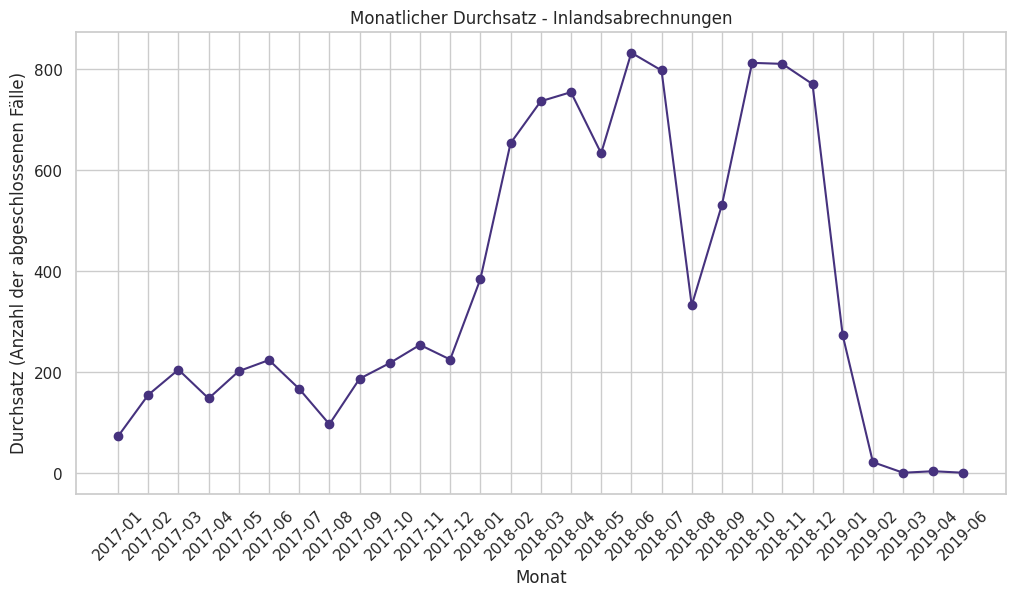

,Month,Throughput
0,2017-01,73
1,2017-02,155
2,2017-03,205
3,2017-04,148
4,2017-05,202
5,2017-06,224
6,2017-07,167
7,2017-08,97
8,2017-09,187
9,2017-10,218


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Extrahiere Abschlusszeiten der Fälle
case_end_times = []
for trace in domestic_log:
    case_end_time = max(event["time:timestamp"] for event in trace)
    case_end_times.append(case_end_time)

# Erstelle DataFrame für Abschlusszeiten
case_end_times_df = pd.DataFrame(case_end_times, columns=['End Time'])

# Füge eine Spalte für den Monat hinzu
case_end_times_df['Month'] = case_end_times_df['End Time'].dt.to_period('M')

# Berechne den monatlichen Durchsatz (Anzahl abgeschlossener Fälle pro Monat)
throughput_df = case_end_times_df.groupby('Month').size().reset_index(name='Throughput')

# Plot des monatlichen Durchsatzes
plt.figure(figsize=(12, 6))
plt.plot(throughput_df['Month'].astype(str), throughput_df['Throughput'], marker='o')
plt.title('Monatlicher Durchsatz - Inlandsabrechnungen')
plt.xlabel('Monat')
plt.ylabel('Durchsatz (Anzahl der abgeschlossenen Fälle)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Ausgabe des monatlichen Durchsatzes
throughput_df


Basierend auf den bereitgestellten Durchsatzdaten ist es interessant zu beobachten, wie der monatliche Durchsatz über die Zeit schwankt:

- **Frühes 2017**: Der Durchsatz ist relativ niedrig, beginnt aber im Laufe des Jahres 2017 allmählich zu steigen.
- **2018**: Im Jahr 2018 sehen wir eine deutliche Steigerung des Durchsatzes, insbesondere von Februar bis Dezember, wobei Spitzenwerte im Juni (832 Fälle) und Oktober (812 Fälle) erreicht werden. Dies deutet auf eine Phase erhöhter Aktivität hin, möglicherweise aufgrund von Änderungen im Prozess oder einem Anstieg der eingereichten Abrechnungen.
- **2019**: Ab Januar 2019 gibt es einen dramatischen Rückgang des Durchsatzes, der im März und April nahezu zum Stillstand kommt. Dies könnte auf eine deutliche Verringerung der Abrechnungsaktivität, eine Prozessänderung oder andere externe Faktoren hindeuten.

Diese Daten bieten wertvolle Einblicke in die saisonalen und jährlichen Trends des Durchsatzes, was auf potenzielle Engpässe oder Änderungen im Prozess hinweisen könnte, die einer tieferen Analyse bedürfen.

### KPIs Auslandsabrechnungsprozess

Der Auslandsabrechnungsprozess stellt zusätzliche Herausforderungen dar, insbesondere im Hinblick auf die rechtzeitige Bearbeitung von Reisegenehmigungen und die Kosteneffizienz. Auch hier ist die **Durchlaufzeit** ein zentraler Indikator, um sicherzustellen, dass Reisegenehmigungen und Abrechnungen rechtzeitig bearbeitet werden. Die **Genehmigungszeiten** in den verschiedenen Phasen der Reisegenehmigung und Abrechnung sind ebenfalls kritisch, da Verzögerungen in diesem Bereich erhebliche Auswirkungen auf die Reisenden haben können. Die **Ablehnungsquote** liefert wichtige Informationen darüber, wie oft Genehmigungen und Abrechnungen abgelehnt werden, was Rückschlüsse auf die Effizienz und Genauigkeit des Prozesses zulässt. Schließlich ist die **Dauer der Nachbearbeitung** ein wichtiger Faktor, der anzeigt, wie lange es dauert, abgelehnte Anträge zu korrigieren und erneut einzureichen, was ebenfalls die Pünktlichkeit und Kosteneffizienz beeinflusst.